### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [1]:
# #
# import sys
# #
# from google.colab import drive
# #
# drive.mount('/content/drive')
# #
# sys.path.append('/content/drive/MyDrive/IntProject')

In [2]:

import sys
#
del sys.modules['data_func']
del sys.modules['utils']
# del sys.modules['model']


KeyError: 'data_func'

In [3]:
# pip install yeoda

In [4]:
# pip install tifftools

In [16]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations,visualize_offline_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from utils import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A

from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import warnings
import rasterio

warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)


In [17]:
# pip install tqdm

In [18]:
# pip install torchvision

### Data Preparation & Augmentation

In [8]:
train_batch_size = 32
val_batch_size = 16
test_batch_size = 4

In [9]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.RandomResizedCrop(256, 256, scale=(0.8, 1.0), p=0.5),
    
], )
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),], )


In [10]:

run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask',
                             './drive/MyDrive/IntProject/train_mask_lacken',
                             train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask', './drive/MyDrive/IntProject/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask',
                             './drive/MyDrive/IntProject/test_mask_lacken', train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './drive/MyDrive/IntProject/model_results3.txt'
    model_file = './drive/MyDrive/IntProject/model3.pt'
else:
    train_set = ImageDataset('./augmentations/train/', './augmentations/train_mask', './augmentations/train_mask_lacken', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./augmentations/val/', './augmentations/val_mask', './augmentations/val_mask_lacken', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./augmentations/test/', './augmentations/test_mask', './augmentations/test_mask_lacken', train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './model_results3.txt'
    model_file = './model3.pt'


In [11]:
len(test_set)

16

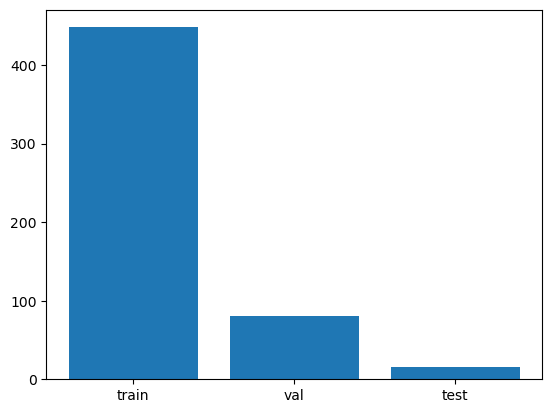

In [12]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


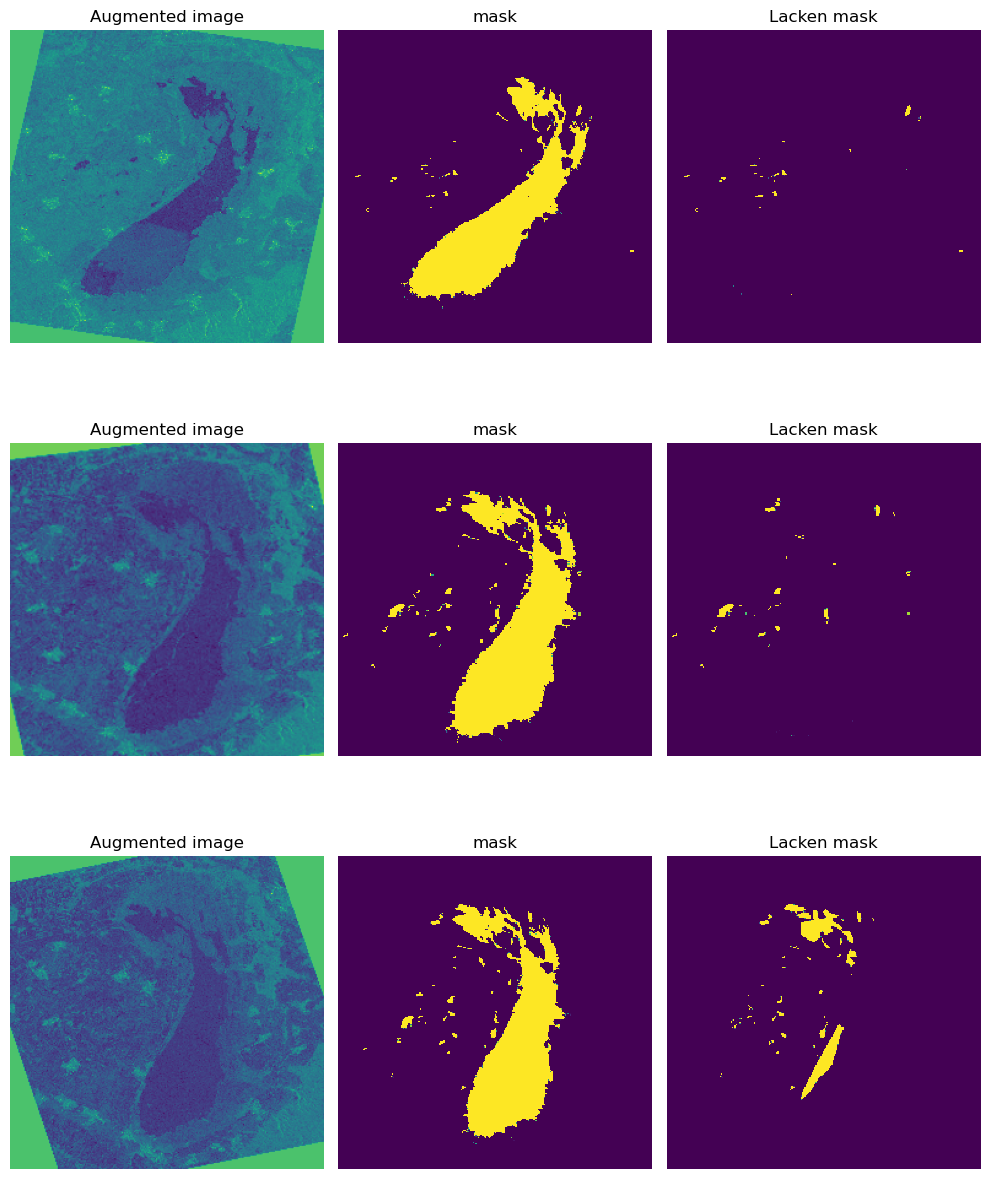

In [13]:
visualize_offline_augmentations(train_set, samples=3)


#### Train & Evaluate

In [21]:
epochs = 50
model = UNet(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
global_step = 0

In [22]:
train_evaluate(model, epochs, trainloader, valloader, optimizer, criterion, dict_file,
               model_file, best_dice=0, patience=10)

  0%|          | 0/50 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, 

 
 Epoch: 1 
TRAIN FULL: Train Loss: 1.1491 | Train DICE Coeff: 0.5243  | Train IoU Coeff: 0.3586| | Train Bal Accuracy: 79.99 | Train Accuracy: 83.04 
TRAIN LACKENS: Train DICE Coeff: 0.0408  | Train IoU Coeff: 0.0132|  | Train Bal Accuracy: 63.46 |  Train Accuracy: 77.23 
VAL FULL: Val Loss: 2.9738 | Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 50.00 | Val Accuracy: 87.20 
VAL LACKENS: Val DICE Coeff: 0.0093 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 50.00 |  Val Accuracy: 99.74| 


  2%|▏         | 1/50 [11:55<9:44:13, 715.38s/it]/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetRe

 
 Epoch: 2 
TRAIN FULL: Train Loss: 0.8512 | Train DICE Coeff: 0.6975  | Train IoU Coeff: 0.5984| | Train Bal Accuracy: 87.79 | Train Accuracy: 93.60 
TRAIN LACKENS: Train DICE Coeff: 0.0469  | Train IoU Coeff: 0.0203|  | Train Bal Accuracy: 66.67 |  Train Accuracy: 86.79 
VAL FULL: Val Loss: 1.3155 | Val DICE Coeff: 0.1402 | Val IoU Coeff: 0.1051 | Val Bal Accuracy: 47.32 | Val Accuracy: 82.82 
VAL LACKENS: Val DICE Coeff: 0.0040 | Val IoU Coeff: 0.0008 | Val Bal Accuracy: 54.28 |  Val Accuracy: 91.54| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

 
 Epoch: 3 
TRAIN FULL: Train Loss: 0.7259 | Train DICE Coeff: 0.7192  | Train IoU Coeff: 0.6194| | Train Bal Accuracy: 89.04 | Train Accuracy: 94.08 
TRAIN LACKENS: Train DICE Coeff: 0.0428  | Train IoU Coeff: 0.0202|  | Train Bal Accuracy: 65.77 |  Train Accuracy: 86.85 
VAL FULL: Val Loss: 2.4871 | Val DICE Coeff: 0.4980 | Val IoU Coeff: 0.2329 | Val Bal Accuracy: 50.58 | Val Accuracy: 57.95 
VAL LACKENS: Val DICE Coeff: 0.0035 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 73.61 |  Val Accuracy: 46.80| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

 
 Epoch: 4 
TRAIN FULL: Train Loss: 0.6077 | Train DICE Coeff: 0.7732  | Train IoU Coeff: 0.6797| | Train Bal Accuracy: 91.58 | Train Accuracy: 95.16 
TRAIN LACKENS: Train DICE Coeff: 0.0408  | Train IoU Coeff: 0.0211|  | Train Bal Accuracy: 67.41 |  Train Accuracy: 86.88 
VAL FULL: Val Loss: 0.6338 | Val DICE Coeff: 0.7351 | Val IoU Coeff: 0.6094 | Val Bal Accuracy: 52.35 | Val Accuracy: 93.40 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0030 | Val Bal Accuracy: 87.84 |  Val Accuracy: 85.83| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

 
 Epoch: 5 
TRAIN FULL: Train Loss: 0.5388 | Train DICE Coeff: 0.7845  | Train IoU Coeff: 0.6920| | Train Bal Accuracy: 92.13 | Train Accuracy: 95.42 
TRAIN LACKENS: Train DICE Coeff: 0.0349  | Train IoU Coeff: 0.0201|  | Train Bal Accuracy: 66.31 |  Train Accuracy: 86.97 
VAL FULL: Val Loss: 0.5048 | Val DICE Coeff: 0.7804 | Val IoU Coeff: 0.6999 | Val Bal Accuracy: 46.09 | Val Accuracy: 95.91 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 85.81 |  Val Accuracy: 90.19| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

 
 Epoch: 6 
TRAIN FULL: Train Loss: 0.4816 | Train DICE Coeff: 0.7990  | Train IoU Coeff: 0.7076| | Train Bal Accuracy: 92.69 | Train Accuracy: 95.68 
TRAIN LACKENS: Train DICE Coeff: 0.0375  | Train IoU Coeff: 0.0209|  | Train Bal Accuracy: 66.06 |  Train Accuracy: 87.00 
VAL FULL: Val Loss: 0.4855 | Val DICE Coeff: 0.8223 | Val IoU Coeff: 0.6710 | Val Bal Accuracy: 51.08 | Val Accuracy: 94.39 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 91.91 |  Val Accuracy: 84.72| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

 
 Epoch: 7 
TRAIN FULL: Train Loss: 0.4525 | Train DICE Coeff: 0.7971  | Train IoU Coeff: 0.7048| | Train Bal Accuracy: 92.29 | Train Accuracy: 95.67 
TRAIN LACKENS: Train DICE Coeff: 0.0372  | Train IoU Coeff: 0.0215|  | Train Bal Accuracy: 67.44 |  Train Accuracy: 87.28 
VAL FULL: Val Loss: 0.9045 | Val DICE Coeff: 0.4225 | Val IoU Coeff: 0.3382 | Val Bal Accuracy: 48.03 | Val Accuracy: 91.35 
VAL LACKENS: Val DICE Coeff: 0.0032 | Val IoU Coeff: 0.0003 | Val Bal Accuracy: 67.19 |  Val Accuracy: 95.20| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

 
 Epoch: 8 
TRAIN FULL: Train Loss: 0.4168 | Train DICE Coeff: 0.8070  | Train IoU Coeff: 0.7223| | Train Bal Accuracy: 92.92 | Train Accuracy: 95.94 
TRAIN LACKENS: Train DICE Coeff: 0.0390  | Train IoU Coeff: 0.0214|  | Train Bal Accuracy: 66.99 |  Train Accuracy: 87.18 
VAL FULL: Val Loss: 0.6266 | Val DICE Coeff: 0.6296 | Val IoU Coeff: 0.5541 | Val Bal Accuracy: 52.51 | Val Accuracy: 93.13 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0035 | Val Bal Accuracy: 81.47 |  Val Accuracy: 89.17| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

 
 Epoch: 9 
TRAIN FULL: Train Loss: 0.3791 | Train DICE Coeff: 0.8208  | Train IoU Coeff: 0.7423| | Train Bal Accuracy: 93.50 | Train Accuracy: 96.33 
TRAIN LACKENS: Train DICE Coeff: 0.0385  | Train IoU Coeff: 0.0218|  | Train Bal Accuracy: 67.07 |  Train Accuracy: 87.46 
VAL FULL: Val Loss: 0.5683 | Val DICE Coeff: 0.7555 | Val IoU Coeff: 0.5720 | Val Bal Accuracy: 55.93 | Val Accuracy: 91.73 
VAL LACKENS: Val DICE Coeff: 0.0058 | Val IoU Coeff: 0.0039 | Val Bal Accuracy: 89.56 |  Val Accuracy: 82.63| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

 
 Epoch: 10 
TRAIN FULL: Train Loss: 0.3533 | Train DICE Coeff: 0.8289  | Train IoU Coeff: 0.7541| | Train Bal Accuracy: 93.86 | Train Accuracy: 96.49 
TRAIN LACKENS: Train DICE Coeff: 0.0373  | Train IoU Coeff: 0.0213|  | Train Bal Accuracy: 67.21 |  Train Accuracy: 87.38 
VAL FULL: Val Loss: 0.2830 | Val DICE Coeff: 0.9088 | Val IoU Coeff: 0.8331 | Val Bal Accuracy: 51.19 | Val Accuracy: 97.62 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 94.29 |  Val Accuracy: 87.67| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwar

 
 Epoch: 11 
TRAIN FULL: Train Loss: 0.3270 | Train DICE Coeff: 0.8365  | Train IoU Coeff: 0.7704| | Train Bal Accuracy: 94.33 | Train Accuracy: 96.80 
TRAIN LACKENS: Train DICE Coeff: 0.0400  | Train IoU Coeff: 0.0230|  | Train Bal Accuracy: 68.79 |  Train Accuracy: 87.64 
VAL FULL: Val Loss: 1.2176 | Val DICE Coeff: 0.2855 | Val IoU Coeff: 0.2735 | Val Bal Accuracy: 58.38 | Val Accuracy: 84.57 
VAL LACKENS: Val DICE Coeff: 0.0112 | Val IoU Coeff: 0.0050 | Val Bal Accuracy: 68.09 |  Val Accuracy: 85.68| 


/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x121498220>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line


#### Evaluating on Test Data

In [23]:
# model = UNet(1,1)
# state_dict = torch.load(model_file)  # Load the state_dict
# model.load_state_dict(state_dict)  # Load weights into the model
# model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Dice Coefficient: 0.8996397256851196
Dice Coefficient Lackens: 0.00603115651756525


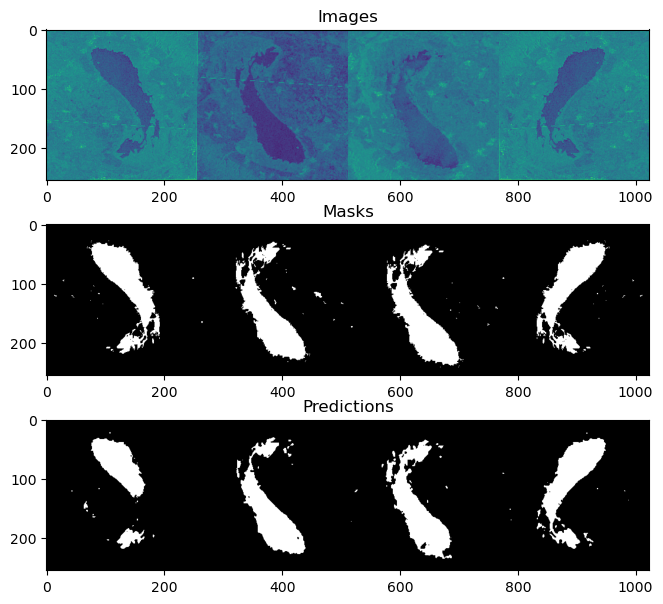

Dice Coefficient: 0.904675304889679
Dice Coefficient Lackens: 0.007174476981163025


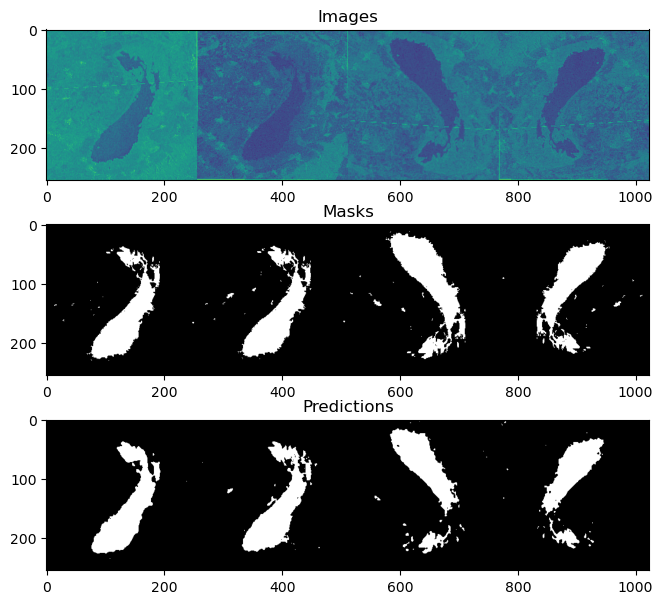

Dice Coefficient: 0.9123720526695251
Dice Coefficient Lackens: 0.007840138860046864


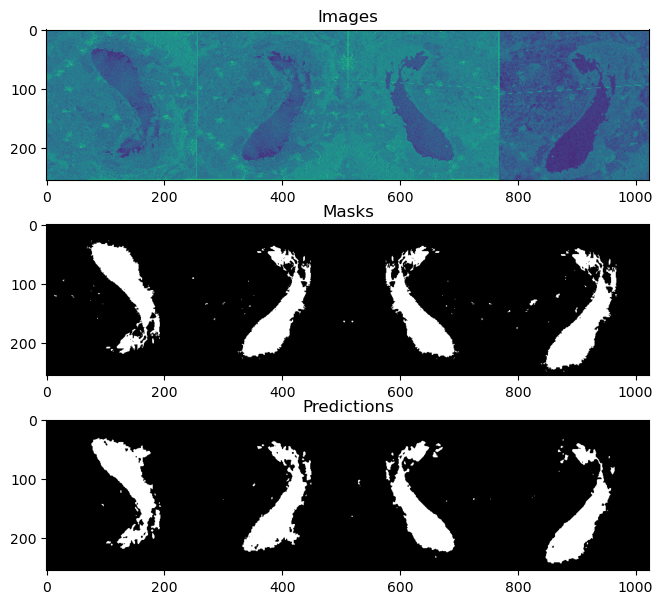

Dice Coefficient: 0.9210032820701599
Dice Coefficient Lackens: 0.008476868271827698


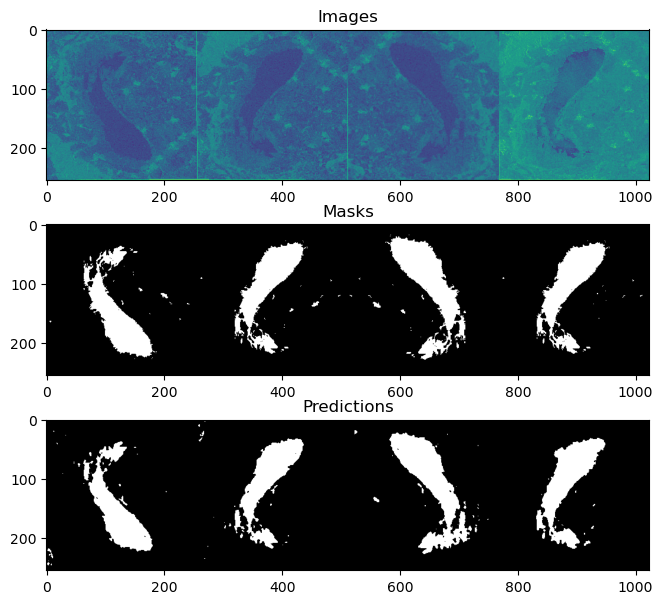

In [24]:
def display_batch(images, masks, pred,lacken_masks):
    print(f"Dice Coefficient: {dice_coeff(pred.to(device), masks.to(device))}")
    print(f"Dice Coefficient Lackens: {dice_coeff(pred.to(device), lacken_masks.to(device))}")

    images = images.permute(0, 2, 3, 1)
    masks = masks.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    pred = pred.cpu().numpy()

    images = np.concatenate(images, axis=1)
    masks = np.concatenate(masks, axis=1)
    pred = np.concatenate(pred, axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(20, 6))
    fig.tight_layout()
    ax[0].imshow(images)
    ax[0].set_title('Images')
    ax[1].imshow(masks, cmap='gray')
    ax[1].set_title('Masks')
    ax[2].imshow(pred, cmap='gray')
    ax[2].set_title('Predictions')

    plt.show()


for images, masks, lacken_masks in testloader:
    with torch.no_grad():

        pred = model(images.to(device)).detach()
        pred = (pred > 0.5).float()


    display_batch(images, masks, pred,lacken_masks)
